In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [5]:
cum_casos = pd.read_csv('Data/cum_casos.csv')
cum_casos

,Data,cum_casos
0,2020-01-02,1
1,2020-01-04,3
2,2020-01-06,4
3,2020-01-07,5
4,2020-01-09,6
...,...,...
467,2021-06-27,26542
468,2021-06-28,26580
469,2021-06-29,26600
470,2021-06-30,26633


# Preparando a variável target: 7 dias para o futuro

In [6]:
# Escalonando os dados por milhares
cum_casos['cum_casos'] = cum_casos['cum_casos']/1000

cum_casos['target'] = cum_casos['cum_casos'].shift(7)
cum_casos.iloc[-10:-1, :]

,Data,cum_casos,target
462,2021-06-22,26.371,25.907
463,2021-06-23,26.419,25.956
464,2021-06-24,26.442,26.059
465,2021-06-25,26.495,26.134
466,2021-06-26,26.529,26.160
467,2021-06-27,26.542,26.229
468,2021-06-28,26.580,26.323
469,2021-06-29,26.600,26.371
470,2021-06-30,26.633,26.419


# Plotando o ACF e PACF: objetivo é encontrar as lag e window features

Text(0.5, 1.0, 'Partial Autocorrelations')

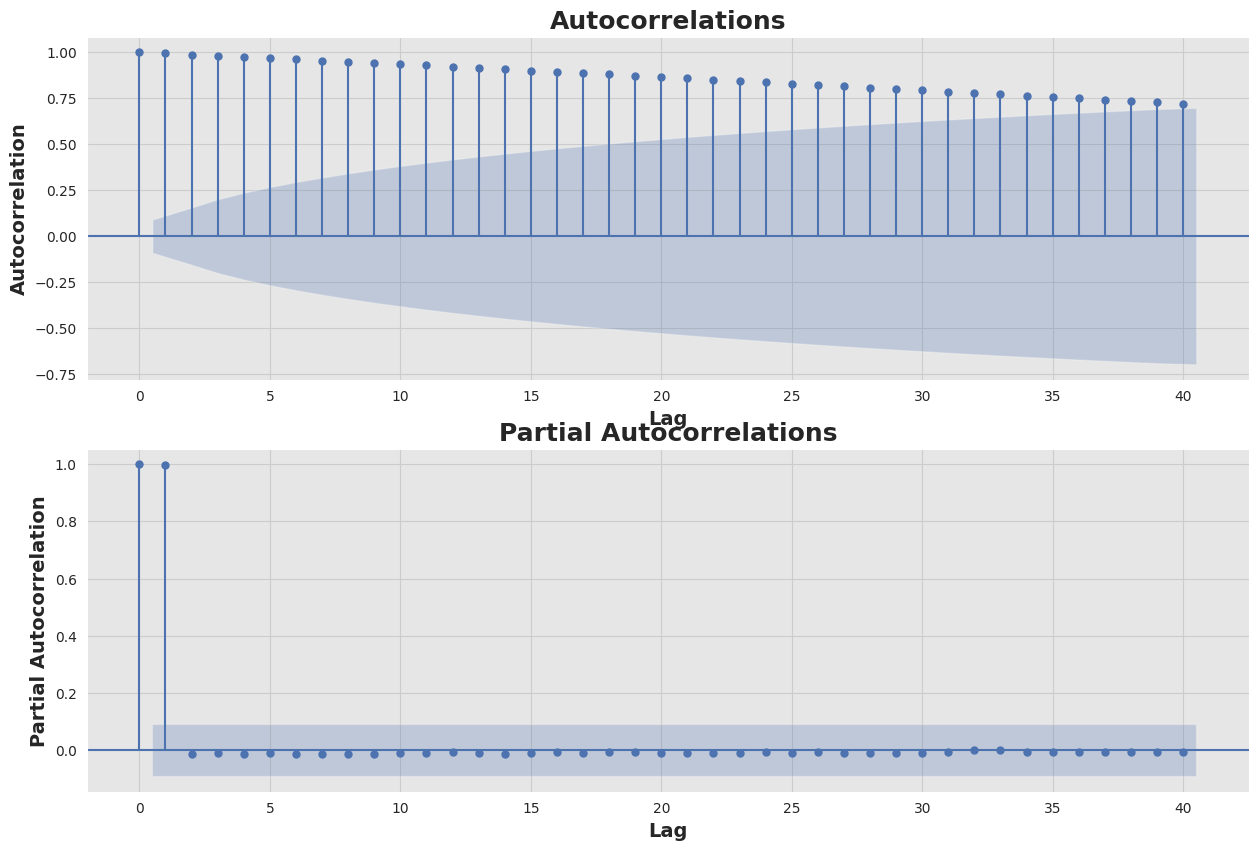

In [7]:
covid_cases = cum_casos.cum_casos
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))

acf_1 = plot_acf(covid_cases.values, lags=40, ax = axs[0])
pacf_1 = plot_pacf(covid_cases.values, lags=40, ax = axs[1])
axs[0].set_title('Autocorrelations', fontsize = 18, fontweight = 'bold')
axs[0].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[0].set_ylabel('Autocorrelation', fontsize = 14, fontweight = 'bold')

axs[1].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[1].set_ylabel('Partial Autocorrelation', fontsize = 14, fontweight = 'bold')
axs[1].set_title('Partial Autocorrelations', fontsize = 18, fontweight = 'bold')


Aparentemente, esse é um fenomeno que é muito mais influenciado por uma média móvel do que por uma lag feature. Dessa forma, vamos utilizar direto uma média móvel do acumulado dos casos de 7 dias pra trás, junto com a quantidade de casos no dia t

# Criando uma window feature de 7 dias para o passado

In [8]:
cum_casos['media_movel'] = cum_casos['cum_casos'].rolling(7).mean()
cum_casos['t'] = [i + 1 for i in range(cum_casos.shape[0])]
cum_casos.iloc[:20,:]

,Data,cum_casos,target,media_movel,t
0,2020-01-02,0.001,NaN,NaN,1
1,2020-01-04,0.003,NaN,NaN,2
2,2020-01-06,0.004,NaN,NaN,3
3,2020-01-07,0.005,NaN,NaN,4
4,2020-01-09,0.006,NaN,NaN,5
5,2020-01-12,0.007,NaN,NaN,6
6,2020-01-16,0.008,NaN,0.004857,7
7,2020-01-22,0.009,0.001,0.006000,8
8,2020-01-31,0.010,0.003,0.007000,9
9,2020-02-01,0.011,0.004,0.008000,10


# Tentando treinar um modelo multidimensional, usando a data no tempo t e a janela de média até t-7 para prever o valor no tempo t+7

In [9]:
cum_casos = cum_casos.dropna()
cum_casos.to_csv('/home/andre/workspace/Pessoal/PGS-Covid19/Data/lag_features.csv')


In [10]:
cum_casos

,Data,cum_casos,target,media_movel,t
7,2020-01-22,0.009,0.001,0.006000,8
8,2020-01-31,0.010,0.003,0.007000,9
9,2020-02-01,0.011,0.004,0.008000,10
10,2020-02-03,0.012,0.005,0.009000,11
11,2020-02-09,0.013,0.006,0.010000,12
...,...,...,...,...,...
467,2021-06-27,26.542,26.229,26.445857,468
468,2021-06-28,26.580,26.323,26.482571,469
469,2021-06-29,26.600,26.371,26.515286,470
470,2021-06-30,26.633,26.419,26.545857,471


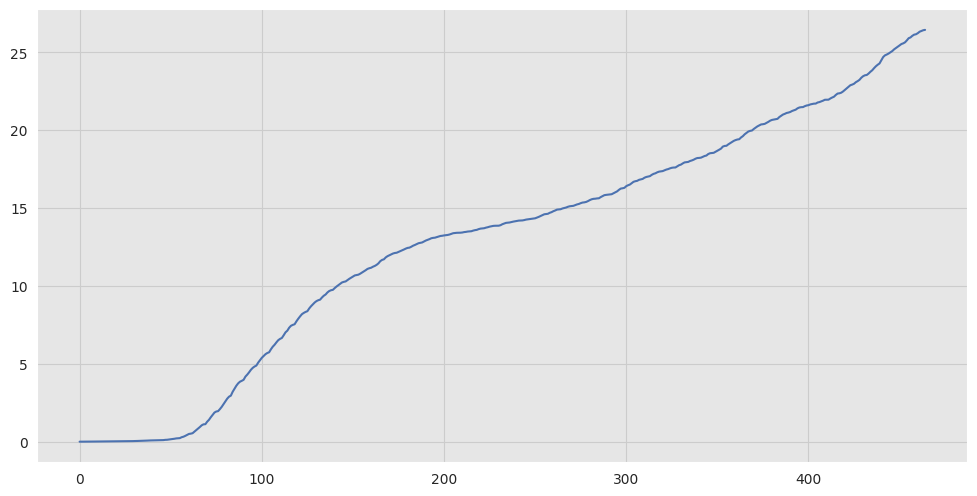

In [11]:

x = np.array(cum_casos[['t', 'cum_casos', 'media_movel']])
y = np.array(cum_casos['target']).reshape(-1,1)

plt.plot(y)

# data = data.reshape(-1, 1)

# # escalona valores por milhares
# CRdata = data/1000
# CRdata  = np.ravel(CRdata)

Dividindo os dados em treino e teste. O teste vai ser 1 mes antes do final dos dados, assim como vinha fazendo antes

In [12]:
x_train = x[:-30]
x_test = x[-30:]

y_train = y[:-30]
y_test = y[-30:]



# Definindo o modelo e realizando o treinamento

In [13]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RBF,DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = ConstantKernel()* Matern(1.0) + DotProduct()
gp1 = GaussianProcessRegressor(kernel = kernel)

gp1.fit(x_train, y_train)


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1))

In [14]:
 # Treinamento do modelo
print("\nLearned kernel: %s" % gp1.kernel_)
params = gp1.kernel_.get_params()

# Calcula R2 do gp1o:
R2_tr  = gp1.score(x_train, y_train)
R2     = gp1.score(x, y)
R2_test = gp1.score(x_test, y_test)


print("\nR2 treinamento: %f" % R2_tr)
print("\nR2 todo intervalo de dados: %f" % R2)
print("\nR2 de teste: %f" % R2_test)


Learned kernel: 1**2 * Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1)

R2 treinamento: 1.000000

R2 todo intervalo de dados: 0.999985

R2 de teste: 0.976568


In [15]:
 #Previsões do modelo
CRpred_tr, sigma_tr = gp1.predict(x_train, return_std=True) # previsão no intervalo de treinamento
CRpred_test, sigma_test = gp1.predict(x_test, return_std=True) # previsão no intervalo de teste
CRpred, sigma   = gp1.predict(x, return_std=True)    # previsão para todo o intervalo de dados

/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [16]:
cum_casos

,Data,cum_casos,target,media_movel,t
7,2020-01-22,0.009,0.001,0.006000,8
8,2020-01-31,0.010,0.003,0.007000,9
9,2020-02-01,0.011,0.004,0.008000,10
10,2020-02-03,0.012,0.005,0.009000,11
11,2020-02-09,0.013,0.006,0.010000,12
...,...,...,...,...,...
467,2021-06-27,26.542,26.229,26.445857,468
468,2021-06-28,26.580,26.323,26.482571,469
469,2021-06-29,26.600,26.371,26.515286,470
470,2021-06-30,26.633,26.419,26.545857,471


In [17]:
CRpred = np.ravel(CRpred)

In [18]:
cum_casos['t'].values

array([  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [19]:
t = np.array(cum_casos['t'])
t = t.reshape(-1,1)
t.shape

(465, 1)

In [24]:
sigma.shape

(465,)

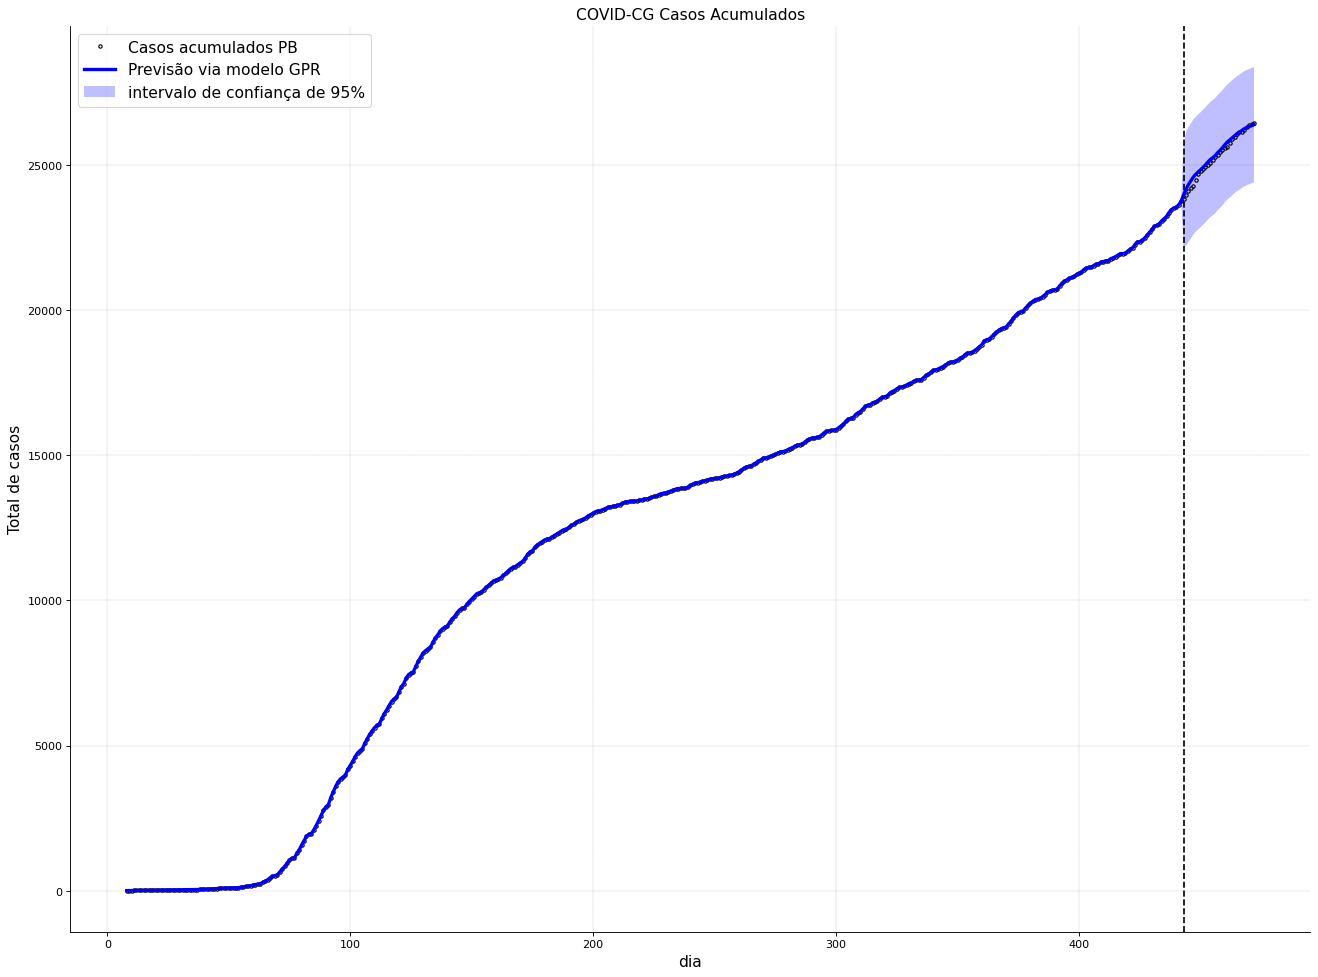

In [20]:
plt.figure(1, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t, y*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.axvline(x = x_test[0][0],linestyle= '--', color = 'black')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)


plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                        (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
        alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
#plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-CG Casos Acumulados', fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

O resultado melhorou consideravelmente para os testes iniciais. Podemos ver que consegue-se dar o fit na curva quase perfeitamente e o intervalo de teste ainda consegue capturar as nuances de variações. O próximo passo é jogar isso daqui numa estrutura de validação cruzada, estudar diferentes funções kernel e analisar o comportamento com a variação do tamanho do dataset

No handles with labels found to put in legend.


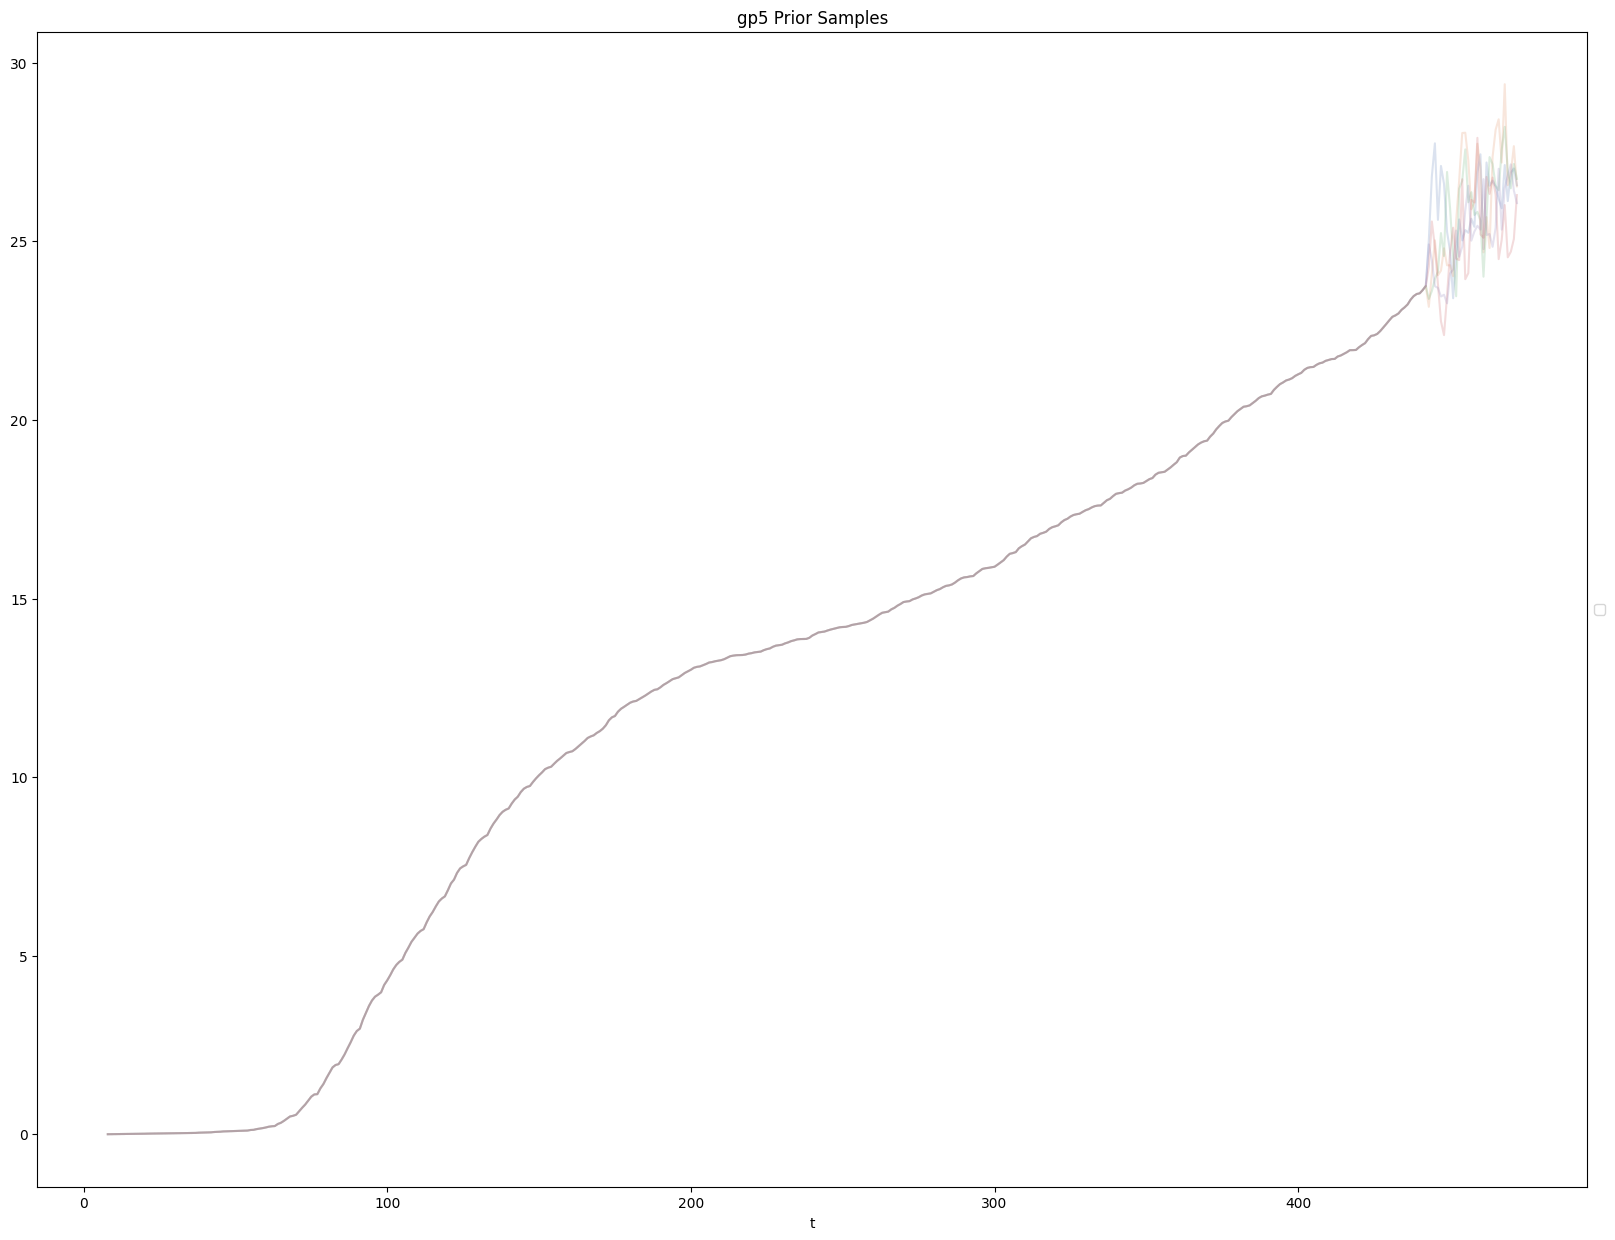

In [21]:

# Prior Sampling
samples = gp1.sample_y(X=x, n_samples=100).reshape(465,100)

fig, ax = plt.subplots(figsize = (20,15))
for i in range(5):
    sns.lineplot(x=t[...,0], y = samples[:, i], color=sns_c[i], alpha=0.2, ax=ax)
#sns.lineplot(x=t[...,0], y=np.ravel(y), color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='gp5 Prior Samples', xlabel='t');

In [22]:
np.ravel(t).shape

(465,)